In [1]:
from __future__ import division
get_ipython().magic('matplotlib inline')
import numpy as np, matplotlib.pyplot as plt, math, numpy.random as npr, pystan as ps
from pylab import plot, show, legend
from time import time
from tqdm import trange

In [2]:
sm = ps.StanModel(file="model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdb84a6f080ca44ccf00761f7296c2e8 NOW.


In [3]:
# T = 10**5
# p = 50
alpha = 0
phi = [0.4,-0.6]
sigmasq = 1

In [11]:
# y = np.zeros(T)
# X = npr.randn(T,p)
# beta = npr.randn(p)/10
# epsilon = np.zeros(T)
# epsilon[:2] = npr.randn(2)
# for t in np.arange(2,T) :
#     epsilon[t] = sum(phi*(epsilon[t-2:t][::-1])) + np.sqrt(sigmasq)*npr.randn()
    
# for t in range(T) : y[t] = alpha + sum(beta*X[t]) + epsilon[t]
# np.save('/xtmp/PIE_time_series_data/ar(2)_errors/y.npy', y)
# np.save('/xtmp/PIE_time_series_data/ar(2)_errors/X.npy', X)
# np.save('/xtmp/PIE_time_series_data/ar(2)_errors/beta.npy', beta)

y = np.load('/xtmp/DC-BATS_data/ar(2)_errors/y.npy')
X = np.load('/xtmp/DC-BATS_data/ar(2)_errors/X.npy')
beta = np.load('/xtmp/DC-BATS_data/ar(2)_errors/beta.npy')

T = len(y)
p = np.shape(X)[1]

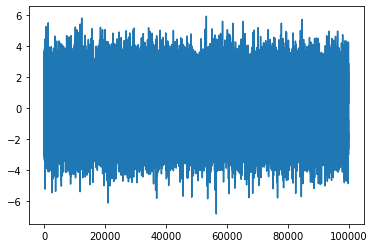

In [10]:
plt.plot(y)

### Sanity check using one chunk:

In [12]:
j = 0
tmin = j*10**4
tmax = (j+1)*10**4
n_chains = 10
n_iter = 10**3

#### Correct power:

In [13]:
m = T/(tmax-tmin)
data = dict(K=tmax-tmin, p=p, m=m, y=y[tmin:tmax], X=X[tmin:tmax].transpose())
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=n_iter)
print(round((time()-start)/60,2), "minutes to run")
trace = fit.extract()

10.16 minutes to run


In [14]:
alpha_CI = np.percentile(trace['alpha'], [5,95])
beta_CI = np.percentile(trace['beta'], [2.5,97.5], axis=0)
CI_contains = (beta_CI[0]<beta)*(beta<beta_CI[1])
print("Beta CI coverage =", np.mean(CI_contains)*100, "%")
print("Beta CI average length =", np.mean(np.abs(beta_CI[1]-beta_CI[0])))
phi_CI = np.percentile(trace['phi'], [2.7,97.5], axis=0)
CI_contains = (phi_CI[0]<phi)*(phi<phi_CI[1])
print(CI_contains)

Beta CI coverage = 50.0 %
Beta CI average length = 0.02052628331841487
[ True  True]


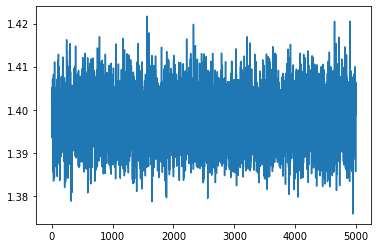

In [15]:
plt.figure(figsize=(6,4))
plt.plot(trace['sigmasq'])

In [17]:
np.mean(trace['sigmasq'])

1.3979881575007318

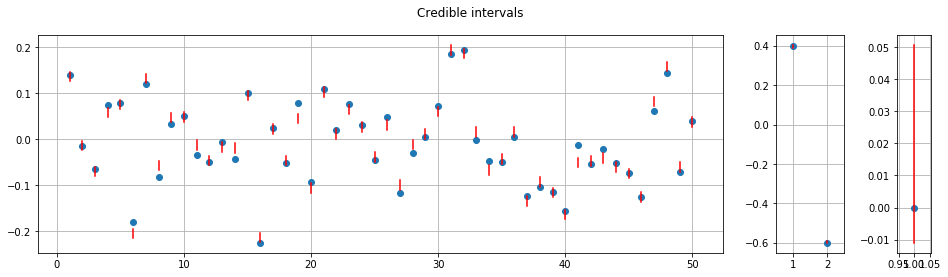

In [16]:
f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [10, 1, 0.5]}, figsize=(16,4))
a0.plot(np.arange(1,p+1), beta, "o")
for i in range(p) :
    a0.plot([i+1,i+1], beta_CI[:,i], "r-")
    a0.grid(True)
a1.plot(np.arange(1,3),phi, "o")
for i in range(len(phi)) :
    a1.plot([i+1,i+1], phi_CI[:,i], "r-")
    a1.grid(True)
a1.set_xlim([1/2,len(phi)+1/2])
a2.plot(1, alpha, "o")
a2.plot([1,1], alpha_CI, "r-")
a2.grid(True)
plt.suptitle("Credible intervals");